# Final Project - Modeling Complex Systems

### Roy Madpis (319091526) And Michael Kobaivanov (206814485)

This is the final project of course Complex Modeling, The instructions for this final project are given in a pdf file that can be found in Moodle.

Drowing networkx graphs:
https://networkx.org/documentation/stable/reference/drawing.html

In [4]:
# pip install tqdm

In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import math
from sklearn.model_selection import train_test_split

import networkx as nx
from tqdm import tqdm ### for cross bar of progress - red color
from tqdm.notebook import tqdm_notebook ### for cross bar of progress - Blue color

import scipy.integrate as spi #for the integrator
%matplotlib inline

In this assignment we'll simulate an imaginary evolving economy and use that simulation to study the wealth distribution within that economy and the effect of an individual's behavior on that individual's wealth.

The assignment is multifaceted in the sense that it requires skills in several areas:
+ learning new topics
+ problem-solving
+ and programming.


You were hired to advise the government of Zubawewe – a tiny tribenation that has just received its independence from Britain. The new government would like to establish a free economy, yet exercise some level of control over it, in an effort to avoid formation of large disparities and inequalities within its population and, as importantly, attempt to prevent poverty.

Some ideas regarding laws that need to be applied towards that end have been considered. **Your mission is to test the
long-term effect of these laws (rules), via simulation, and advise the government regarding the repercussions of their application**.

+ As part of the process of forming a new economy in the state, a new currency will be created and the government wishes to **hand out an equal amount of the new currency to all its current citizens**.

+ Moreover, it also wishes to grant a **fixed amount to each newborn child** (as long as both parents are citizens).


The ideas the government wishes to test in are detailed below. 


### The required simulation has two main components:
1. a growing/changing network, where each **node** represents an **agent** (person) and the **edges** connected to a node **represent this agent's** connections

2. A system of inter-agent wealth transactions wherein agents transact some of their wealth. 



Each node has several characteristics (traits), as detailed below.

Three of these traits need to be drawn from random distributions (which are based on behaviors observed in surveys of the Zubawewean population).

For each node ("individual"), you should keep track of the parameters characterizing that node.

The parameters include:
1. **saving-propensity $\sigma_p$**:
This value represents the agent's **inclination to save** and is randomly drawn, for each node, from a
beta(2, 10.7) distribution, shifted by 0.01, thereby forcing a minimum saving requirement, and capped at 0.7.
i.e.: $𝑚𝑖𝑛(0.01 + 𝑛𝑝.𝑟𝑎𝑛𝑑𝑜𝑚.𝑏𝑒𝑡𝑎(2, 10.7), 0.7).$

2. **Social-propensity $\phi$:**
This value represents the agent's **social inclination** (inclination towards connecting with other agents) a
randomly drawn standard-Normal distributed value. (Thus, the average agent social propensity is 0) 


3. **Business-propensity** $\beta$ :**
This value represents the **agent's business inclination** (or willingness to take risks) and is randomly drawn, for each node, from a lognorml distribution, using the following formula:
$$𝑚𝑖𝑛((𝑛𝑝.𝑟𝑎𝑛𝑑𝑜𝑚.𝑙𝑜𝑔𝑛𝑜𝑟𝑚𝑎𝑙(𝑚𝑒𝑎𝑛 = 3.4, 𝑠𝑖𝑔𝑚𝑎 = .55) + 1.4)/350, 0.5)$$

4. **Birth**:
A **timestamp** of **when the node was created**

5. **Wealth 𝑤:**
Initially, **at "birth", set to 100**. (This is the amount the government intends to grant each existing citizen as well as
each newborn.) 



The simulation should be run for **35,500 timesteps**. Throughout the run, two processes take place:
1. Network growth/alteration,
2. Inter-agent wealth transactions,

### Initial network:
Initially, the network is a 200-node E-R graph with 𝑝 = 0.15 , ie, each
existing node is connected to an average of 30 nodes. The internode
connections (edges) are to be randomly generated. This initial state
represents the current population of Zimbawewe 


### Network dynamics:
Once the initial network is set up, the **dynamics of the system** are characterized by **three processes** that take place at various times, namely:
+ **node deletion**
+ **node generation**
+ **connections (edges) alterations**. 


1. **Nodes get deleted (die) when they reach an "age" of 𝑡 = 18,250**.
At that point, their wealth is equally distributed between all
of their immediate (𝑘 = 1) connections.
NOTE: removal of "deceased" nodes should be done prior to
addition of new nodes, i.e., the calculation of the number of
nodes that need to be added at time t should be done after the
removal of deceased nodes. 



Each newly generated node (i.e. a node added after the initial
network is set) is initially connected to 2 randomly selected
interconnected nodes ("parents") and to all of the immediate
(𝑘 = 1) connections of those two nodes. Note that the 2 parents
must be interconnected, i.e. 1st degree neighbors. 

# Some functions for the simulations:

In [6]:
### Code for statistics evaluation
### function to get a data framewith all the nodes and their attributes + df with statistics

def statistics_simulation(time_stamp_index, graph):
    
    df = pd.DataFrame.from_dict(graph.nodes.keys())
    df["age"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_age_name).values())
    df["wealth"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_wealth_name).values())
    df["sigma_p"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_sigma_p_name).values())
    df["beta"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_beta_name).values())
    df["phi"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_phi_name).values())
    df.rename(columns = {0:'node_index'}, inplace = True)
    
    df_nodes = df
    
    t = time_stamp_index
    
    index_of_statistics = "Statistics for time stamp " + str(t)

    #mean wealth
    mean_wealth = np.round(np.mean(df.wealth),3)

    #median wealth
    median_wealth = np.round(np.median(df.wealth),3)

    # min(wealth), i.e., agent with the smallest wealth
    node_with_smallest_wealth = df[df.wealth == df.wealth.min()].head(1)
    node_with_smallest_wealth = np.round(node_with_smallest_wealth,3).add_suffix("_min_wealth").transpose()
    node_with_smallest_wealth.rename(columns = {node_with_smallest_wealth.columns[0]:index_of_statistics}, inplace = True)

    #max(wealth), i.e., the agent with the highest wealth
    node_with_max_wealth = df[df.wealth == df.wealth.max()].head(1)
    node_with_max_wealth = np.round(node_with_max_wealth,3).add_suffix("_max_wealth").transpose()
    node_with_max_wealth.rename(columns = {node_with_max_wealth.columns[0]:index_of_statistics}, inplace = True)

    #percent population below the poverty line (defining the poverty line as 35) 
    population_below_povery_line = df[df.wealth < poverty_line].shape[0]
    percent_population_below_poverty_line = np.round(population_below_povery_line/df.shape[0],3)

    df_statistics = pd.DataFrame(data = [[mean_wealth, median_wealth, percent_population_below_poverty_line, treasury]],
                                 columns = ["mean wealth", "median wealth", "Percent Population below poverty line", "treasury Capital"],
                                 index=[index_of_statistics])

    df_statistics = df_statistics.transpose()
    df_statistics_new = pd.concat([df_statistics, node_with_smallest_wealth], axis = 0)
    df_statistics_new = pd.concat([df_statistics_new, node_with_max_wealth], axis = 0)

    return(df_nodes, df_statistics_new)

In [5]:
### The following function gets as input a data frame (df) with all the nodes and their attributes,
#this is in fact the output of the function `statistics_simulation`

def graphs_simulation(df):

    #### plot wealth distribution
    plt.figure(figsize=(6,5))
    hist_sns = sns.histplot(data = df, x = "wealth")#.set(title='Wealth Distribution')
    hist_sns.axes.set_title("Wealth Distribution",fontsize=20) # wealth distribution
    ############################################################################################

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13,13))
    ### wealth vs sigma
    regplot_wealth_sigma = sns.regplot(x="sigma_p", y="wealth", data = df, ax=axs[0,0]) #reg plot of wealth vs sigma
    regplot_wealth_sigma.axes.set_title("Wealth vs sigma",fontsize=20)#line plot of wealth vs sigma

    sns.lineplot(x = "sigma_p", y = "wealth", data = df, ax=axs[0,1])

    ### wealth vs beta
    regplot_wealth_beta = sns.regplot(x="beta", y="wealth", data = df, ax=axs[1,0]) #reg plot of wealth vs beta
    regplot_wealth_beta.axes.set_title("Wealth vs beta",fontsize=20)  #line plot of wealth vs beta

    sns.lineplot(x = "beta", y = "wealth", data = df, ax=axs[1,1])

    ### Wealth vs phi
    regplot_wealth_phi = sns.regplot(x="phi", y="wealth", data = df, ax=axs[2,0]) #.set(title='Wealth vs Phi - line plot with regression line')
    regplot_wealth_phi.axes.set_title("Wealth vs phi",fontsize=20)  #line plot of wealth vs phi
    sns.lineplot(x = "phi", y = "wealth", data = df, ax=axs[2,1]) #.set(title='Wealth vs Phi - scatter plot with regression line')

    ### space between each subplot
    plt.subplots_adjust(hspace = 0.3)

    plt.show()
    print("---------------------------------------- ********************************* ----------------------------------------")



## Running the Zimbabuwe Simulation 

The dir log_simulation already exist
Finish pre-simulation preperation in 24.166 Seconds 



  0%|          | 0/30001 [00:00<?, ?it/s]

Time stamp number:  0
Average time in each time-stamp:  0 Seconds
Total number of nodes: 201
Total number of edges: 3103


,Statistics for time stamp 0
mean wealth,100.000
median wealth,100.000
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,0.000
age_min_wealth,1.000
wealth_min_wealth,100.000
sigma_p_min_wealth,0.159
beta_min_wealth,0.059
phi_min_wealth,0.294


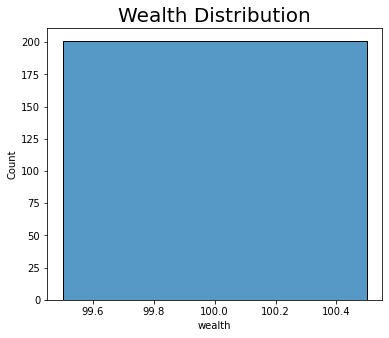

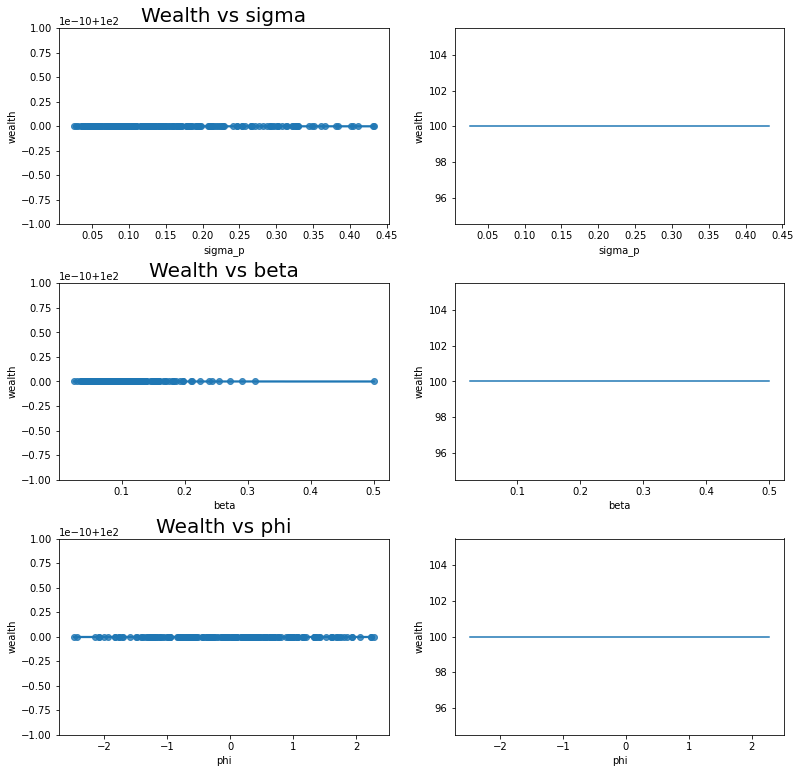

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  5000
Average time in each time-stamp:  0.004 Seconds
Total number of nodes: 207
Total number of edges: 3452


,Statistics for time stamp 5000
mean wealth,100.000
median wealth,94.189
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,84.000
age_min_wealth,5001.000
wealth_min_wealth,44.228
sigma_p_min_wealth,0.109
beta_min_wealth,0.123
phi_min_wealth,-0.657


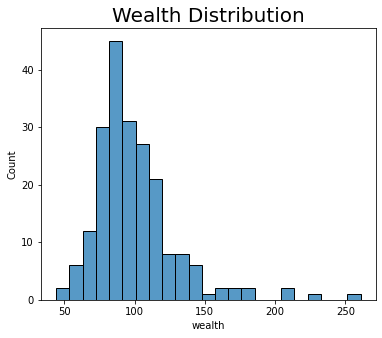

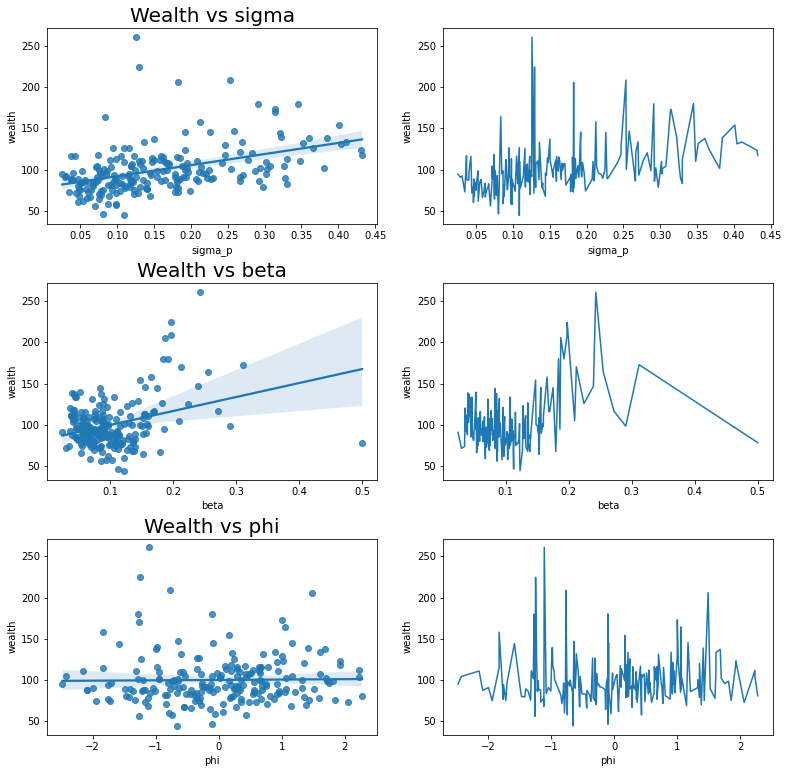

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  10000
Average time in each time-stamp:  0.004 Seconds
Total number of nodes: 232
Total number of edges: 5390


,Statistics for time stamp 10000
mean wealth,100.000
median wealth,98.795
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,74.000
age_min_wealth,10001.000
wealth_min_wealth,45.288
sigma_p_min_wealth,0.038
beta_min_wealth,0.076
phi_min_wealth,-0.435


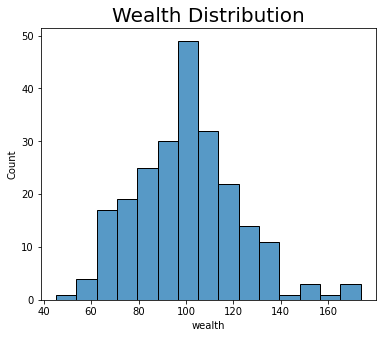

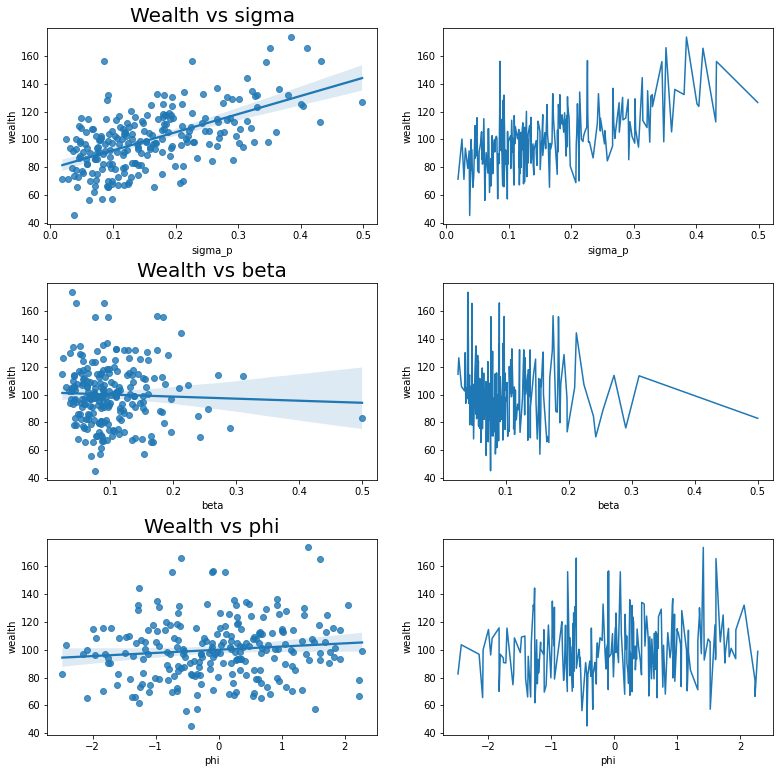

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  15000
Average time in each time-stamp:  0.004 Seconds
Total number of nodes: 334
Total number of edges: 19774


,Statistics for time stamp 15000
mean wealth,100.000
median wealth,96.386
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,157.000
age_min_wealth,15001.000
wealth_min_wealth,53.488
sigma_p_min_wealth,0.098
beta_min_wealth,0.154
phi_min_wealth,-0.342


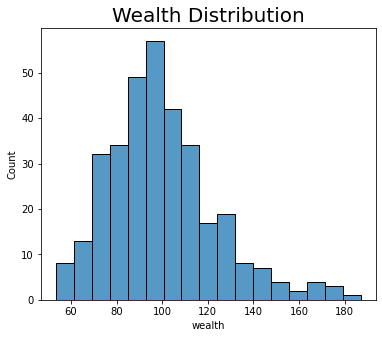

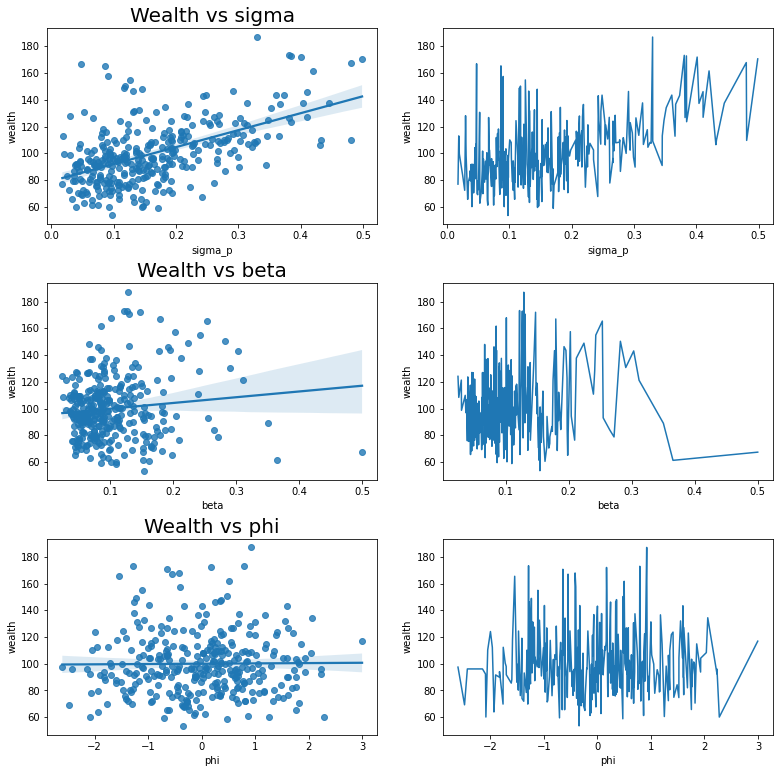

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  20000
Average time in each time-stamp:  0.008 Seconds
Total number of nodes: 753
Total number of edges: 273017


,Statistics for time stamp 20000
mean wealth,126.947
median wealth,124.196
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,683.000
age_min_wealth,1751.000
wealth_min_wealth,57.170
sigma_p_min_wealth,0.031
beta_min_wealth,0.218
phi_min_wealth,-1.731


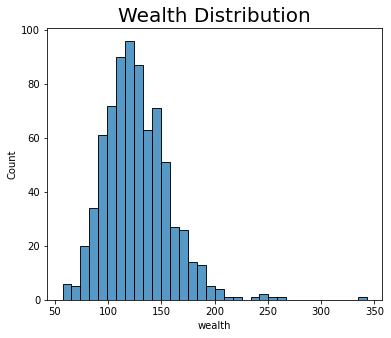

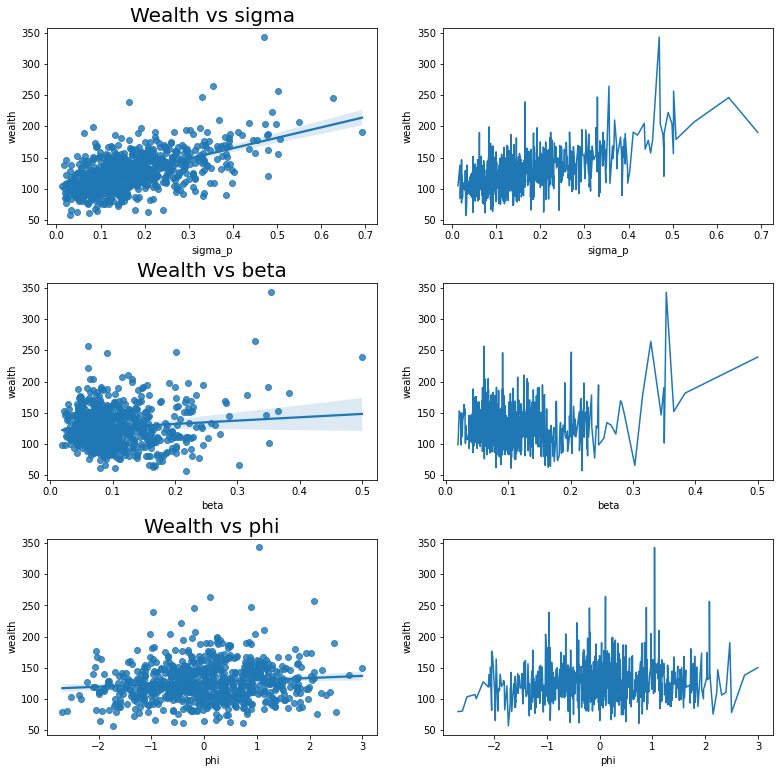

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  25000
Average time in each time-stamp:  0.023 Seconds
Total number of nodes: 2415
Total number of edges: 2903031


,Statistics for time stamp 25000
mean wealth,108.775
median wealth,105.742
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,1317.000
age_min_wealth,3219.000
wealth_min_wealth,31.338
sigma_p_min_wealth,0.087
beta_min_wealth,0.453
phi_min_wealth,-0.074


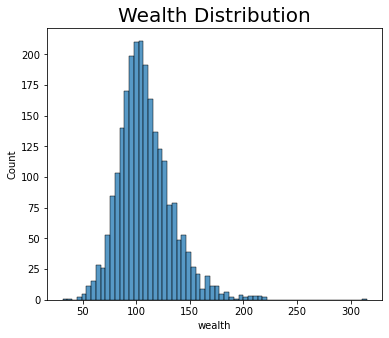

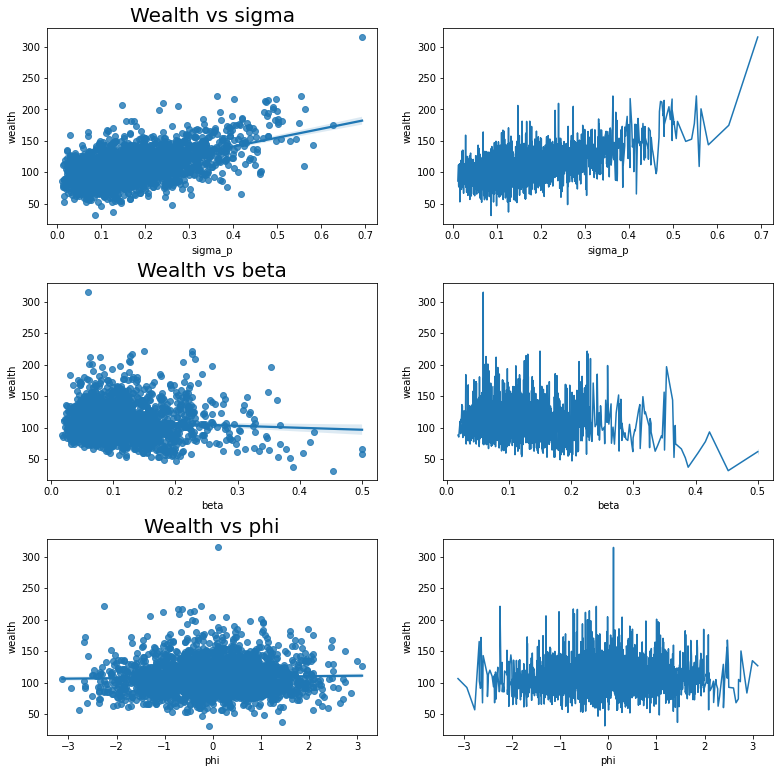

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  30000
Average time in each time-stamp:  0.102 Seconds
Total number of nodes: 8087
Total number of edges: 32677810


,Statistics for time stamp 30000
mean wealth,103.127
median wealth,100.765
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,4376.000
age_min_wealth,2812.000
wealth_min_wealth,27.122
sigma_p_min_wealth,0.065
beta_min_wealth,0.361
phi_min_wealth,0.685


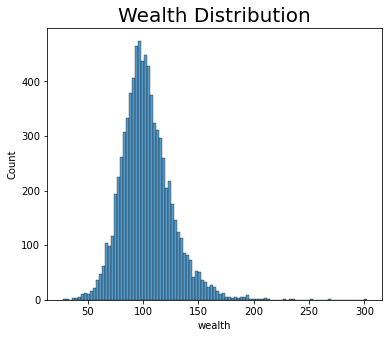

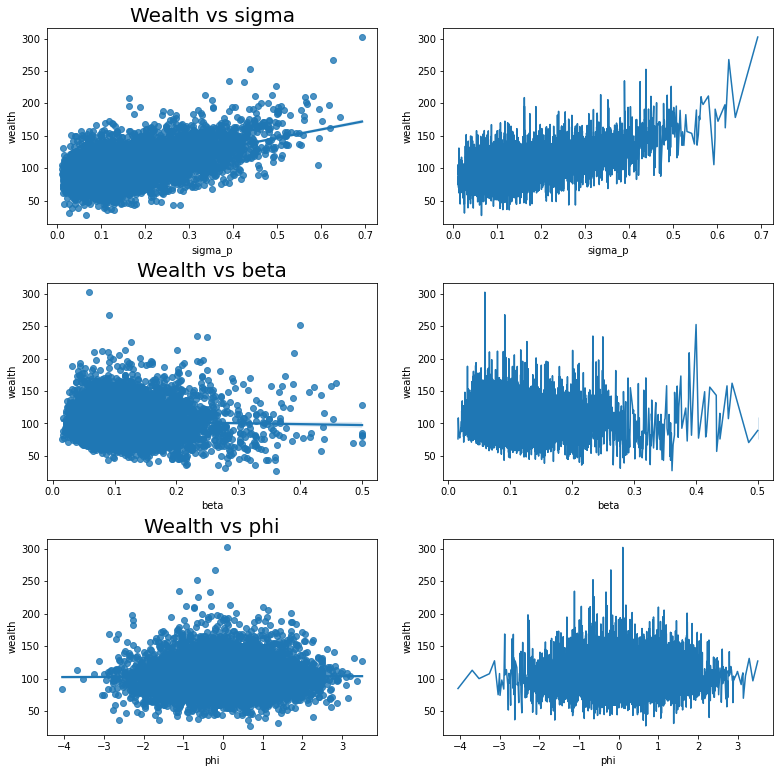

---------------------------------------- ********************************* ----------------------------------------


In [8]:
### Varibales to follow time 
start_time = time.time()
list_times_in_each_time_stamp = []
restart_list_times_in_each_time_stamp = True #if this is true then the function will restart the list of list_times_in_each_time_stamp
# in this way, in each k time-stamps when the function prints the statistics table + graph and dispalys the average time
#in each time stamp, it will restart the counting and thus in each such print, lets say every 1000 time-stamps,
#we wil get the average time in each time stamp only in the last 1000 time stamps

########################################## Simulation
simulation_length = 30001 #35500
die_age = 18250 #18250
nodes_f = 41000 #41000  #limiting factor on the total number of nodes
#graph = ER_graph
attribute_age_name = "age"
attribute_birth_name = "birth"
attribute_wealth_name = "wealth"
attribute_sigma_p_name = "sigma_p"
attribute_beta_name = "beta"
attribute_phi_name = "phi"
ages_to_modify_connections = list(range(0, simulation_length+1, 500))[1:]

poverty_line = 35

verbose_check=  False
print_statistics_and_graphs = True
treasury = 0
print_graph_in_each_k_steps = 5000 #1000

#create log dir for the simulation
### in the log dir we would like to create a text file and insert to it the progration status
log_dir_name = "log_simulation"
log_file_name = "log_simulation.txt"
try:
    os.mkdir(log_dir_name)
    print("creating log directory", log_dir_name, "to store the log of the simulation")
except:
    print("The dir", log_dir_name ,"already exist")

path_for_log_file_name = os.path.join(log_dir_name, log_file_name)

from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S (Date: %d.%m.%y)")
current_time = "Current Time: " + current_time + "   *****************************************   "

with open(path_for_log_file_name, 'a') as f:
    f.write(current_time + '\n\n')

################################################## Initiate the settings    
n = 200
p = 0.15 #Probability for edge creation.
seed = 1998
graph = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)

## add age attribute to the nodes in the graph
start_age_value = 0
nx.set_node_attributes(graph, values = start_age_value, name= attribute_age_name) #age
##add wealth value to the nodes in the graph
start_wealth_value = 100
nx.set_node_attributes(graph, values = start_wealth_value, name= attribute_wealth_name) #wealth

# set random attribute values
for node in graph.nodes:
    sigma_p_value = min(0.01 + np.random.beta(2,10.7), 0.7) #random sigma p value - – this value represents the agent's
    #inclination to save - forcing a minimum saving requirement, and capped at 0.7. 
    
    phi_value = np.random.normal(0, 1, 1)  #random phi value - this value represents the agent's social inclination (inclination towards connecting with other agents)
    
    #this value represents the agent's business inclination (or willingness to take risks) 
    beta_value = min((np.random.lognormal(mean = 3.4, sigma = 0.55) + 1.4)/350, 0.5)
    
    ## add sigma_p attribute to the nodes in the graph
    graph.nodes[node][attribute_sigma_p_name] = sigma_p_value
    
    ## add phi attribute to the nodes in the graph
    graph.nodes[node][attribute_phi_name] = phi_value

    ## add beta attribute to the nodes in the graph
    graph.nodes[node][attribute_beta_name] = beta_value

    ## add birth timestamp
    graph.nodes[node][attribute_birth_name] = 0
    
    
last_node_index = max(list(graph.nodes))  #store the last index of the node in the graph - for creating mpre nodes later

print("Finish pre-simulation preperation in", round(time.time() - start_time, 3) , "Seconds \n")
####################################### THE For loop - running the simulation ######################################
for t in tqdm_notebook(range(simulation_length)):
    start_time_stamp_time = time.time()

    #print("time = ", t+1)
    #update the age of each node - add 1 to it
    nodes_to_remove = []
    
    if verbose_check:
        print("------------------------------------------------------------------")
        #print(graph.nodes)
        #print("need_to_add_nodes:", need_to_add_nodes)
        print("Number of nodes:",len(graph.nodes))
        print("Number of edges:",len(graph.edges))
        print(last_node_index)
    
    for node in graph.nodes:
        ##### update age attribute
        graph.nodes[node][attribute_age_name] = graph.nodes[node][attribute_age_name] + 1
        
        ### if node reached die age - add it to list of nodes to remove
        if graph.nodes[node][attribute_age_name] >= die_age:
            nodes_to_remove.append(node)
        
        ### if the age of the node is 500, 1000, 1500, etc
        if graph.nodes[node][attribute_age_name] in ages_to_modify_connections :
            if verbose_check: print("handling edges")
            formula_for_edges = int(np.round(np.random.normal(loc = graph.nodes[node][attribute_phi_name]),0))

            if formula_for_edges < 0 : #then randomly remove edges
                nodes_neighbors = list(graph.neighbors(node))
                if len(nodes_neighbors) > 2:
                    #if you are asked to remove more edges than the amount of existing edgesm than just remove all of them
                    numer_of_edges_to_remove = min(np.abs(formula_for_edges),len(nodes_neighbors)-2) #k
                    
                    ### now we need to randomly select K EDGES TO REMOVE, K = |formula_for_edges|
                    remove_edges_from_the_following_nodes = random.sample(nodes_neighbors, numer_of_edges_to_remove)

                    ### removing the edges:
                    if len(remove_edges_from_the_following_nodes) > 0:
                        for edge_to_remove in remove_edges_from_the_following_nodes:
                            graph.remove_edge(node, edge_to_remove)

            else: #then add edges
                nodes_neighbors = list(graph.neighbors(node))
                ### now we need to randomly select K EDGES TO add from the ones that are not already connected, K = |formula_for_edges|
                not_1st_relatives_nodes = list(set(graph.nodes) - set(nodes_neighbors))
                numer_of_edges_to_add = min(formula_for_edges, len(not_1st_relatives_nodes))
                add_edges_from_the_following_nodes  = random.sample(not_1st_relatives_nodes, numer_of_edges_to_add)
            
                for edge_to_add in add_edges_from_the_following_nodes:
                    graph.add_edge(node, edge_to_add)
        
        #if verbose_check: print(graph.nodes[node]) 
        
    #remove nodes that reached die age, before removing them:
    # equally distribute their wealth
    for node_to_remove in nodes_to_remove:
        neighbors_of_node_i_that_die = list(graph.neighbors(node_to_remove)) #this list contains the neighbors of node i
        #that we want to split between them the wealth of node i that die
        if len(neighbors_of_node_i_that_die) > 0: #if there is at least one neighbor
            wealth_splitted = graph.nodes[node_to_remove][attribute_wealth_name]/len(neighbors_of_node_i_that_die)
            for neighbor_j_of_node_i_that_die in neighbors_of_node_i_that_die:
                graph.nodes[neighbor_j_of_node_i_that_die][attribute_wealth_name] += wealth_splitted
        else: #save the wealth to fund
            treasury += graph.nodes[node_to_remove][attribute_wealth_name]
        
        graph.remove_node(node_to_remove)
          
    #N_t = int(n + (nodes_f - n)*((1)/(1+math.exp(-((t/3500)-1)))))#the required amount of nodes in time t
    
    N_t = int(n + (nodes_f - n)/(1+math.exp(-((t/3500)-10)))) #the required amount of nodes in time t

    need_to_add_nodes = N_t - len(graph.nodes)
    
    if verbose_check: print(need_to_add_nodes)
        
    #need_to_add_nodes = 10
    ### Add more nodes to the graph:
    for i in range(need_to_add_nodes):
        last_node_index +=1
        random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
        neighbors_node_i = list(graph.neighbors(random_chosen_neighbor)) #find the neighbors of node A
        counter_loops = 0
        while len(neighbors_node_i) < 1 and counter_loops <= 30: #as long as the number of neighbors of node A is 
            #less than 1, than we need to try to find another node with at least 1 neighbor, we will try this at max 20 times
            counter_loops +=1
            random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
            neighbors_node_i = list(graph.neighbors(random_chosen_neighbor)) #find the neighbors of node A
        if len(neighbors_node_i) > 0:
            random_neighbor_of_neighbor_i = random.choice(neighbors_node_i) #chose one of the neighbors of node A in random - node B
            neighbor_of_random__neighbor_of_neighbor_i =  list(graph.neighbors(random_neighbor_of_neighbor_i)) #find node B neighbors
            all_first_degree_neighbors_of_parents = [random_chosen_neighbor] + neighbors_node_i + [random_neighbor_of_neighbor_i] + neighbor_of_random__neighbor_of_neighbor_i
            all_first_degree_neighbors_of_parents = list(set(all_first_degree_neighbors_of_parents)) #take only unique values
        
        graph.add_node(last_node_index)

        ###set age attribute, wealth attribute, sigma_p, beta and phi attributes:
        sigma_p_value = min(0.01 + np.random.beta(2,10.7), 0.7) #random sigma p value - – this value represents the agent's
        #inclination to save - forcing a minimum saving requirement, and capped at 0.7. 
        phi_value = np.random.normal(0, 1, 1)  #random phi value - this value represents the agent's social inclination (inclination towards connecting with other agents)
        #this value represents the agent's business inclination (or willingness to take risks) 
        beta_value = min((np.random.lognormal(mean = 3.4, sigma = 0.55) + 1.4)/350, 0.5)
        
        graph.nodes[last_node_index][attribute_age_name] = start_age_value #age
        graph.nodes[last_node_index][attribute_wealth_name] = start_wealth_value #wealth
        graph.nodes[last_node_index][attribute_sigma_p_name] = sigma_p_value #sigma p
        graph.nodes[last_node_index][attribute_beta_name] = beta_value #beta
        graph.nodes[last_node_index][attribute_phi_name] = phi_value #phi
        graph.nodes[last_node_index][attribute_birth_name] = t #birth

        if len(all_first_degree_neighbors_of_parents) >0:
            for node_to_connect in all_first_degree_neighbors_of_parents:
                #print(node_to_connect)
                graph.add_edge(last_node_index, node_to_connect)

    ###### TRANSACTIONS --> happen after all the updates and at each 3 time stampe: 3,6,9,12 ...
    if t%3==0 and t!=0:
        ### At each transaction time, we first divide the existing nodes into two equal-sized groups,
        #which we'll designate A and B. if the overall number of nodes at that time is odd,
        #one node should be randomly selected and removed from the transacting nodes
        num_of_nodes_in_transactions_group = int(math.floor(len(graph.nodes)/2))

        A_Payers ,B_receivers = train_test_split(np.asarray(graph.nodes),train_size=num_of_nodes_in_transactions_group, test_size = num_of_nodes_in_transactions_group, shuffle = True)

        ### sorting the two groups of nodes by the beta (decreasing)
        A_Payers = sorted(A_Payers, key=lambda n: -graph.nodes[n][attribute_beta_name])
        B_receivers = sorted(B_receivers, key=lambda n: -graph.nodes[n][attribute_beta_name])
        
        ### Performing transaction for every per of payer and reciever
        for payer_receiver_i in range(len(A_Payers)):
            A_payer_i = A_Payers[payer_receiver_i]
            B_receiver_i = B_receivers[payer_receiver_i]

            payer_wealth = graph.nodes[A_payer_i][attribute_wealth_name]
            payer_sigma = graph.nodes[A_payer_i][attribute_sigma_p_name]
            #beta
            payer_beta = graph.nodes[A_payer_i][attribute_beta_name]
            receiver_beta = graph.nodes[B_receiver_i][attribute_beta_name]
            mean_beta = (payer_beta  + receiver_beta)/2

            payment = payer_wealth * (1-payer_sigma) *(mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01)))
            payment = float(payment)
     
            
            if payer_wealth>=payment : #perform transaction as the payer has enough wealth for the transaction
                graph.nodes[A_payer_i][attribute_wealth_name] -=  payment
                graph.nodes[B_receiver_i][attribute_wealth_name] +=  payment

    
    if print_statistics_and_graphs and t%print_graph_in_each_k_steps == 0 or t==simulation_length-1: #and t!=0:
        ### function to get a data framewith all the nodes and their attributes + df with statistics

        df_nodes, df_statistics = statistics_simulation(time_stamp_index = t, graph = graph)
        if len(list_times_in_each_time_stamp) < 1:
            average_time_in_time_stamp = 0
        else: 
            average_time_in_time_stamp = round(sum(list_times_in_each_time_stamp) / len(list_times_in_each_time_stamp), 3)
        
        print("Time stamp number: ", t)
        print("Average time in each time-stamp: ", average_time_in_time_stamp, "Seconds")
        print(f"Total number of nodes: {len(graph.nodes)}")
        print(f"Total number of edges: {len(graph.edges)}")
        display(df_statistics)
        graphs_simulation(df = df_nodes)
        
        if restart_list_times_in_each_time_stamp:
            list_times_in_each_time_stamp = []

    ##### for the log file
    
    # num_of_nodes = "Total Number of nodes: " + str(len(graph.nodes))
    # num_of_edges = "Total Number of edges: " + str(len(graph.edges))
    # num_nodes_to_remove = "Total Number of nodes that were removed: " + str(len(nodes_to_remove))
    # num_nodes_to_add = "Total Number of nodes that were added: " + str(need_to_add_nodes)
    
    # with open(path_for_log_file_name, 'a') as f:
    #     print_stat = "Current time-stamp: " + str(t+1) + "     ||| Status at the end of this time-stamp:"
    #     f.write(print_stat+'\n')

    #     f.write(num_of_nodes+ '\n')
    #     f.write(num_of_edges+ '\n')
    #     f.write(num_nodes_to_remove+ '\n')
    #     f.write(num_nodes_to_add+ '\n\n')
        
    #     if ((t+1)%print_graph_in_each_k_steps) ==1 or t==simulation_length-1: #and t!=0:
    #         mean_wealth_log =  "Mean wealth: " + str(df_statistics.loc["mean wealth"][0])
    #         median_wealth_log =  "Median wealth: " + str(df_statistics.loc["median wealth"][0])
    #         Percent_Population_below_poverty_line_log =  "Percent Population below poverty line: " + str(df_statistics.loc["Percent Population below poverty line"][0])
    #         wealth_min_wealth_log =  "Wealth of Min wealth node: " + str(df_statistics.loc["wealth_min_wealth"][0])
    #         wealth_max_wealth_log =  "Wealth of MAX wealth node: " + str(df_statistics.loc["wealth_max_wealth"][0])
    #         Treasury_Capital_log =  "Treasury Capital: " + str(df_statistics.loc["treasury Capital"][0])

    #         f.write("Statistics:"+ '\n')
    #         f.write(mean_wealth_log+ '\n')
    #         f.write(median_wealth_log+ '\n')
    #         f.write(Percent_Population_below_poverty_line_log+ '\n')
    #         f.write(wealth_min_wealth_log+ '\n')
    #         f.write(wealth_max_wealth_log+ '\n')
    #         f.write(Treasury_Capital_log+ '\n')

    #    f.write("-------------------------- ***********************---------------------- "+ '\n\n')
    end_time_stamp_time = time.time() - start_time_stamp_time
    list_times_in_each_time_stamp.append(end_time_stamp_time)
    #print(len(graph.nodes))